In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV

from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from utilities import get_hot_data, get_comments, remove_short_comments, build_model, print_my_examples

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

tf.get_logger().setLevel('ERROR')

Version:      2.5.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7
VAL_FRACTION = 0.25
MIN_COMMENT_LEN = 25
TOP_N = 5
MODEL_NAME = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# MORE ABOUT MODEL NAMES: 
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1"
# we also tested these solutions with dimension equals to 128 but accuracy 
# is a bit lower (0.85 for 128 vs 0.86 for 50) and training sometimes stops 
# unexpectedly for memory limit
#
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
# "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50-with-normalization/1"
# there is no difference between normalization and not so we use the one 
# without normalization

## GET DATA

In [5]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '307002',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/C9U2E51tkzLljewFEGQ74g__thumb/img/4KV3wj3NiJDgGTh3zmW0_8Ph3Zc=/fit-in/200x150/filters:strip_icc()/pic5837347.jpg',
  'name': 'Regicide',
  'yearpublished': '2020'},
 {'id': '337627',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEztwcUQ__thumb/img/Ov6eWR87PZ2O1XYQtXMO6KvfzOg=/fit-in/200x150/filters:strip_icc()/pic6153324.jpg',
  'name': 'Voidfall',
  'yearpublished': '2022'}]

In [6]:
def get_game_by_id(game_id, field='name'):
    for a in hot_array:
        if a['id'] == str(game_id):
            return a[field]

In [7]:
try:
    comments_df = pd.read_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

missing csv file, getting new data using API...
page number = 10 (max: 100, len: 30)
page number = 20 (max: 100, len: 24)
page number = 30 (max: 100, len: 19)
page number = 40 (max: 100, len: 13)
page number = 50 (max: 100, len: 10)
page number = 60 (max: 100, len: 6)
page number = 70 (max: 100, len: 6)
page number = 80 (max: 100, len: 4)
page number = 90 (max: 100, len: 3)
page number = 100 (max: 100, len: 1)
comments_df shape: (131759, 4)


,id,username,rating,value
0,307002,AgentMeat,2,"only solo, played with normal deck of cards, s..."
1,307002,Akuden,8,Kickstarted. Tried out the game solo and at 2 ...
2,307002,amqueue,N/A,kickstarter
3,307002,andrewkapish,N/A,Unplayed
4,307002,Angelo the Magician,9,I only play the solo version and that one is ...
...,...,...,...,...
131754,167791,z_zadar,9,Some games are so much fun. Others can be a li...
131755,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
131756,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
131757,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [8]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  
comments_df["value"] = comments_df["value"].astype(str)

In [9]:
# REMOVE URLs FROM COMMENTS
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 20651 for 'remove_short_comments' - min len: 25 - method: unrated


In [10]:
# REMOVE NON ENGLISH COMMENTS
# !conda install -c conda-forge langdetect
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)
# comments_df = add_comments_lang(comments_df)
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [11]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

9          20915
10         19618
8          19452
7          10375
N/A         8394
           ...  
8.09           1
9.312          1
8.73333        1
6.53           1
9.098          1
Name: rating, Length: 631, dtype: int64

In [12]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(102714, 5)

In [13]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(8394, 5)

## CREATE TRAINING AND VALIDATION DATA

In [14]:
# use rated comments (reviews) to train the model

In [15]:
rated_comments = rated_comments.sample(frac=1)

In [16]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [17]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


"Excellent, this is the first dungeon crawler/campaign game I introduced to my wife and she didn't want to stop playing, we put bout 50 plus hours in just a few weeks off playing and the asymmetry between each of the characters and enemies is just brilliant."

In [18]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'Spiele gerne mit wenn ich gefragt werde, würde es aber nicht vorschlagen.'

## COMPOSE MODEL

In [19]:
hub_layer = hub.KerasLayer(MODEL_NAME, input_shape=[], dtype=tf.string, trainable=True)

## CLASSIFIER

In [20]:
def build_classifier():
    return build_model(hub_layer=None, pre_trained_model_name=MODEL_NAME, model_type='classifier', verbose=0)


estimator = KerasClassifier(build_fn=build_classifier, epochs=100, batch_size=1024, verbose=2, validation_split=VAL_FRACTION)
x_train_clf = np.array(list(rated_comments.value))
y_train_clf = np.array(list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_clf, y_train_clf, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)])

Epoch 1/100
51/51 - 5s - loss: 0.5693 - accuracy: 0.7985 - val_loss: 0.4847 - val_accuracy: 0.8598
Epoch 2/100
51/51 - 3s - loss: 0.4351 - accuracy: 0.8577 - val_loss: 0.3839 - val_accuracy: 0.8616
Epoch 3/100
51/51 - 3s - loss: 0.3446 - accuracy: 0.8631 - val_loss: 0.3276 - val_accuracy: 0.8722
Epoch 4/100
51/51 - 3s - loss: 0.2918 - accuracy: 0.8857 - val_loss: 0.3051 - val_accuracy: 0.8832
Epoch 5/100
51/51 - 3s - loss: 0.2578 - accuracy: 0.8998 - val_loss: 0.2979 - val_accuracy: 0.8859
Epoch 6/100
51/51 - 3s - loss: 0.2322 - accuracy: 0.9103 - val_loss: 0.2986 - val_accuracy: 0.8854
Epoch 7/100
51/51 - 3s - loss: 0.2117 - accuracy: 0.9182 - val_loss: 0.3047 - val_accuracy: 0.8826
Epoch 8/100
51/51 - 3s - loss: 0.1941 - accuracy: 0.9267 - val_loss: 0.3133 - val_accuracy: 0.8785
Epoch 9/100
51/51 - 3s - loss: 0.1796 - accuracy: 0.9328 - val_loss: 0.3265 - val_accuracy: 0.8751
Epoch 10/100
51/51 - 3s - loss: 0.1669 - accuracy: 0.9382 - val_loss: 0.3394 - val_accuracy: 0.8732
34/34 - 0

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001AC8EE31640>,
             param_grid={})

In [21]:
classifier = clf.best_estimator_
classifier_history_dict = classifier.model.history.history

In [22]:
classifier_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = classifier_history_dict['accuracy']
val_acc = classifier_history_dict['val_accuracy']
loss = classifier_history_dict['loss']
val_loss = classifier_history_dict['val_loss']

In [24]:
epochs = range(1, len(acc) + 1) 

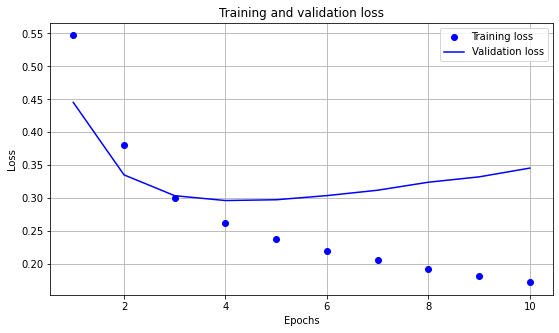

In [25]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

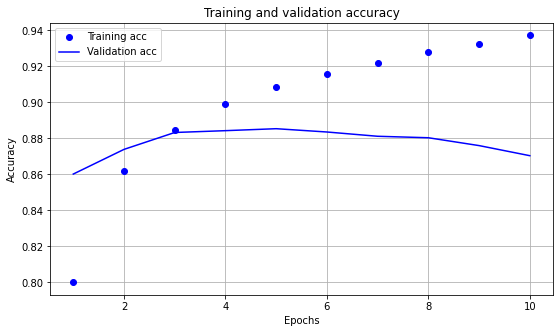

In [26]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [27]:
inputs = x_train_clf[:10]
outputs = y_train_clf[:10]
results = classifier.predict(tf.constant(inputs), verbose=0)
print_my_examples(inputs, results, outputs)

input:
"Spiele gerne mit wenn ich gefragt werde, würde es aber nicht vorschlagen."
score: 0.000000
actual: 0

input:
"Excellent, this is the first dungeon crawler/campaign game I introduced to my wife and she didn't want to stop playing, we put bout 50 plus hours in just a few weeks off playing and the asymmetry between each of the characters and enemies is just brilliant."
score: 1.000000
actual: 1

input:
"Its #1 for a reason."
score: 1.000000
actual: 1

input:
"Always fun, always crying about how imba the game is but always a twist in the end when it comes down to the victory points."
score: 1.000000
actual: 1

input:
"Selmina igra."
score: 1.000000
actual: 1

input:
"1 Play.  Like Viticulture - I appreciate it without thinking it was particularly fun.  Definitely interested in more plays though."
score: 1.000000
actual: 1

input:
"best game for 2"
score: 1.000000
actual: 1

input:
"My favorite space game of all time. Never a bad time, win or lose.  2nd edition production quality is

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [28]:
## APPLY MODEL ON NON-RATED COMMENTS

In [29]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = classifier.predict(tf.constant(list(not_rated_comments.value.astype(str))))
print_my_examples(list(not_rated_comments.value), results, limit=10)

9/9 - 0s
input:
"Terra Mystica in space. I like this theming better."
score: 1.000000

input:
"WTP 1/4 [AREA CONTROL] 3-4 players; 60-90 minutes; The love child of Midgard and Chaos in the Old World (who was unfortunately born with the defect of card drafting)"
score: 1.000000

input:
"Sam says very thematic but very MofM feel, but not sure. More reviews of meh gameplay."
score: 0.000000

input:
"It does look like one of the better LCG's out there & I love the theme, but I refuse to get sucked into these any longer. I hate the collectivity aspect, as it’s a wallet succubus. When I purchase a game, I like to have the game."
score: 1.000000

input:
"I hear good things so I want to try"
score: 1.000000

input:
"I sucked at this game. Then I played it a bunch with Shelby and now I'm pretty good at it. By the third round, at the latest, what you're leaving becomes as or more important than what you are taking. I find that sort of layered choice thrilling."
score: 1.000000

input:
"We liked 

## REGRESSOR

In [30]:
def build_regressor():
    return build_model(hub_layer, pre_trained_model_name=MODEL_NAME, model_type='regressor', verbose=0)


estimator = KerasRegressor(build_fn=build_regressor, epochs=100, batch_size=512, verbose=0, validation_split=VAL_FRACTION)
x_train_reg = np.array(list(rated_comments.value))
y_train_reg = np.array(list(rated_comments.rating.astype(float)))

clf = GridSearchCV(
    estimator, 
    cv=3, 
    param_grid={}
)
clf.fit(x_train_reg, y_train_reg, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=5, min_delta=0.001)])

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001B00006DF70>,
             param_grid={})

In [31]:
regressor = clf.best_estimator_
regressor_history_dict = regressor.model.history.history

In [32]:
regressor_history_dict.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

In [33]:
mean_squared_error = regressor_history_dict['mean_squared_error']
val_mean_squared_error = regressor_history_dict['val_mean_squared_error']
loss = regressor_history_dict['loss']
val_loss = regressor_history_dict['val_loss']

In [34]:
epochs = range(1, len(mean_squared_error) + 1) 

In [35]:
print(f"MEAN SQUARED ERROR (VALIDATION SET): {val_mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (VALIDATION SET): 2.14


In [36]:
print(f"MEAN SQUARED ERROR (TRAINING SET): {mean_squared_error[-1]:.2f}")

MEAN SQUARED ERROR (TRAINING SET): 1.13


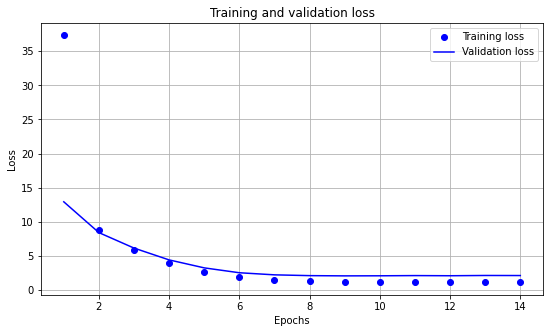

In [37]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

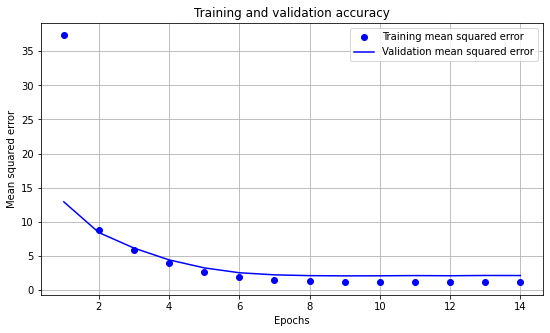

In [38]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, mean_squared_error, 'bo', label='Training mean squared error')
plt.plot(epochs, val_mean_squared_error, 'b', label='Validation mean squared error')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.legend()

plt.show()

In [39]:
inputs = x_train_reg[:10]
outputs = y_train_reg[:10]
results = clf.best_estimator_.predict(tf.constant(inputs), verbose=0)
for i in range(len(inputs)):
    print(f"input: \n\"{inputs[i]}\"\nscore: {results[i]:.2f}\nactual: {outputs[i]:.2f} \n")

input: 
"Spiele gerne mit wenn ich gefragt werde, würde es aber nicht vorschlagen."
score: 7.09
actual: 6.00 

input: 
"Excellent, this is the first dungeon crawler/campaign game I introduced to my wife and she didn't want to stop playing, we put bout 50 plus hours in just a few weeks off playing and the asymmetry between each of the characters and enemies is just brilliant."
score: 8.62
actual: 9.00 

input: 
"Its #1 for a reason."
score: 8.62
actual: 10.00 

input: 
"Always fun, always crying about how imba the game is but always a twist in the end when it comes down to the victory points."
score: 9.57
actual: 9.00 

input: 
"Selmina igra."
score: 8.72
actual: 8.00 

input: 
"1 Play.  Like Viticulture - I appreciate it without thinking it was particularly fun.  Definitely interested in more plays though."
score: 7.49
actual: 7.50 

input: 
"best game for 2"
score: 9.07
actual: 9.00 

input: 
"My favorite space game of all time. Never a bad time, win or lose.  2nd edition production q

## COMPARE CLASSIFIER VS REGRESSOR

In [40]:
not_rated_comments = not_rated_comments.sample(frac=1)
inputs = list(not_rated_comments.value.astype(str))[:10]

clf_results = classifier.predict(inputs, verbose=0)
reg_results = regressor.predict(inputs, verbose=0)
for i in range(len(inputs)):
    print(f"""\"{inputs[i]}\"
    reg score: {reg_results[i]:.2f}
    clf score: {clf_results[i][0]}
""")

"Purchased from Boardgame Guru in autumn 2016"
    reg score: 5.08
    clf score: 1

"initial impression: much heavier dose of polyomino tile laying than expected, numerous pathways to explore and score points, never felt tight until maybe the last round (with 4p)"
    reg score: 7.20
    clf score: 1

"I'm really into diverse characters/factions that radically change the nature of the game.  I don't know if I'd like the wargame heart of Root, and I don't know if I'd ever actually play it much."
    reg score: 7.62
    clf score: 1

"Trevligt spel, men kanske inte favoriten än så länge."
    reg score: 8.39
    clf score: 1

"Sold to Roger O., who I owe a beverage at Origins '17. "
    reg score: 6.22
    clf score: 0

"Acquired @ Strategicon, Feb 2017. Never opened it.  Never played it.  Purged it."
    reg score: 6.98
    clf score: 1

"Traded.  While it certainly is a fun game, it took too long to play."
    reg score: 6.76
    clf score: 0

"KS Edition with Constructs and Undead mi

C:\Users\dev999\.conda\envs\tensorflow2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


### RESULTS
It seems that the regressor is much more accurate compared to the binary classifier => **let's use the regressors results to fix the BGG rating**

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [41]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 115746 |          8.73 |           1949 |
| 124361 |          8.19 |           3970 |
| 162886 |          8.37 |           3721 |
| 167355 |          8.42 |           2021 |
| 167791 |          8.20 |           8538 |


In [42]:
not_rated_comments['rating'] = regressor.predict(list(not_rated_comments.value.astype(str)))

In [43]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments['rating'] = not_rated_comments['rating'].clip(0, 10)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 115746 |          8.31 |            266 |
| 124361 |          8.00 |            258 |
| 162886 |          8.06 |            327 |
| 167355 |          8.34 |            215 |
| 167791 |          8.20 |            454 |


In [44]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [45]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/C9U2E51...","<a href=""https://boardgamegeek.com/boardgame/3...",7.978351,8.048379,7.985183,1,2020
1,"<img src=""https://cf.geekdo-images.com/hItZjdD...","<a href=""https://boardgamegeek.com/boardgame/3...",10.000000,8.188942,8.490785,2,2022
2,"<img src=""https://cf.geekdo-images.com/_al0scM...","<a href=""https://boardgamegeek.com/boardgame/2...",7.517381,8.096305,7.665191,3,2021
3,"<img src=""https://cf.geekdo-images.com/Q96PxRV...","<a href=""https://boardgamegeek.com/boardgame/3...",7.155260,7.311945,7.163435,4,2021
4,"<img src=""https://cf.geekdo-images.com/PhjygpW...","<a href=""https://boardgamegeek.com/boardgame/3...",8.041972,7.885986,8.031388,5,2020


In [46]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [47]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Regicide,7.978351,8.048379,7.985183,1,2020
2,,Voidfall,10.000000,8.188942,8.490785,2,2022
3,,Ankh: Gods of Egypt,7.517381,8.096305,7.665191,3,2021
4,,Descent: Legends of the Dark,7.155260,7.311945,7.163435,4,2021
5,,Dune: Imperium,8.041972,7.885986,8.031388,5,2020


In [48]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,10.000000,8.188942,8.490785,2,2022
2,,Eclipse: Second Dawn for the Galaxy,8.738676,8.003076,8.628773,49,2020
3,,War of the Ring: Second Edition,8.731068,8.310544,8.680567,47,2012
4,,Brass: Birmingham,8.678120,8.209862,8.637144,23,2018
5,,Gloomhaven: Jaws of the Lion,8.543655,8.011601,8.495678,25,2020


In [49]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,War of the Ring: Second Edition,8.731068,8.310544,8.680567,47,2012
2,,Brass: Birmingham,8.678120,8.209862,8.637144,23,2018
3,,Eclipse: Second Dawn for the Galaxy,8.738676,8.003076,8.628773,49,2020
4,,Gloomhaven: Jaws of the Lion,8.543655,8.011601,8.495678,25,2020
5,,Voidfall,10.000000,8.188942,8.490785,2,2022


In [50]:
# model.save('saved_model\my_model')

In [51]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [52]:
# some examples on "long" comments vs short comments

In [53]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')

In [54]:
some_long_comments.apply(lambda c: print(f"\"{c['value']}\" ({get_game_by_id(c['id'])}) \nscore: {c['rating']:.2f}\n"), axis=1);

"It's a little dense and themeless for me. Certainly a solid game, but feels too much like crunching numbers and not enough like playing." (Brass: Birmingham) 
score: 3.79

"[b]Accessories:[/b] [url= Flight [color=#7540A6](Standard European)[/color][/url][url=  Maracaibo: Metal Coins[/url] " (Maracaibo) 
score: 5.53

"everybody thinks they play da game. But is the game that play you. No chance, No choose. Bad game and too expensive" (Root) 
score: 5.60

"Played once in a two player game, and found it lacking for 2 players. I think this one needs to have 4 players to be fully enjoyed. I like flexibility in my games, so that they can be enjoyed with all numbers of players that it lists. I felt too constricted to have 4 players to really enjoy it. " (Root) 
score: 6.48

"Status: Organizing Kickstarter: EB Magister Pledge  Own: Complete Collection  +Upgrade Kit +Promos(Update) Sleeves: Organization: Miniatures: Notes: 1. RDPL" (Black Rose Wars) 
score: 6.73

"Much, much more cut-throat tha

## RANDOM FOREST - TEST

In [55]:
# no support for Windows at the moment - waiting for it to test